## Credit Card Application Approvals
<p>We'll use the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">Credit Card Approval dataset</a> from the UCI Machine Learning Repository. 
    
The Approach:
<li>Import libraries, load and view the dataset, ensure correct datatypes, convert ?/blanks/etc. into nan, and run basic exploratory analysis (statistics, pairplot, other plots) </li>
<li>Use isloation random forest algorithm (an ensemble algorithm) & Score </li>
<li>Use Local Outlier Factor Algorithm </li>
<li>Hyperparameter tuning.</li>
<li>Build ML Pipeline.</li>
</ul>

## Initial Data Import
<li>Load and view the dataset, ensure correct datatypes, and run basic exploratory analysis (statistics, pairplot, other plots) </li>

In [43]:
#Parsing, loading, analyzing data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#Statistical Analysis
from scipy.stats import ttest_ind, chi2_contingency
#Plotting
import seaborn as sns
from matplotlib import pyplot as plt
#Preprocessing & ML
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
#Pipelining
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [2]:
cc_df = pd.read_csv('cc_approvals.data', header=None)
cc_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [3]:
cols = ['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'ApprovalStatus']
cc_df.columns = cols
cc_df.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [4]:
cc_df.shape

(690, 16)

In [5]:
#Check NaN entries (if '?' etc., convert to nan)
cc_df.replace('?', np.nan, inplace=True)
cc_df.ZipCode.replace('00000', np.nan, inplace=True)

In [6]:
cc_df.dtypes

Gender             object
Age                object
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
Ethnicity          object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
DriversLicense     object
Citizen            object
ZipCode            object
Income              int64
ApprovalStatus     object
dtype: object

In [7]:
cc_df['Age'] = pd.to_numeric(cc_df['Age'])
cc_df.dtypes

Gender             object
Age               float64
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
Ethnicity          object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
DriversLicense     object
Citizen            object
ZipCode            object
Income              int64
ApprovalStatus     object
dtype: object

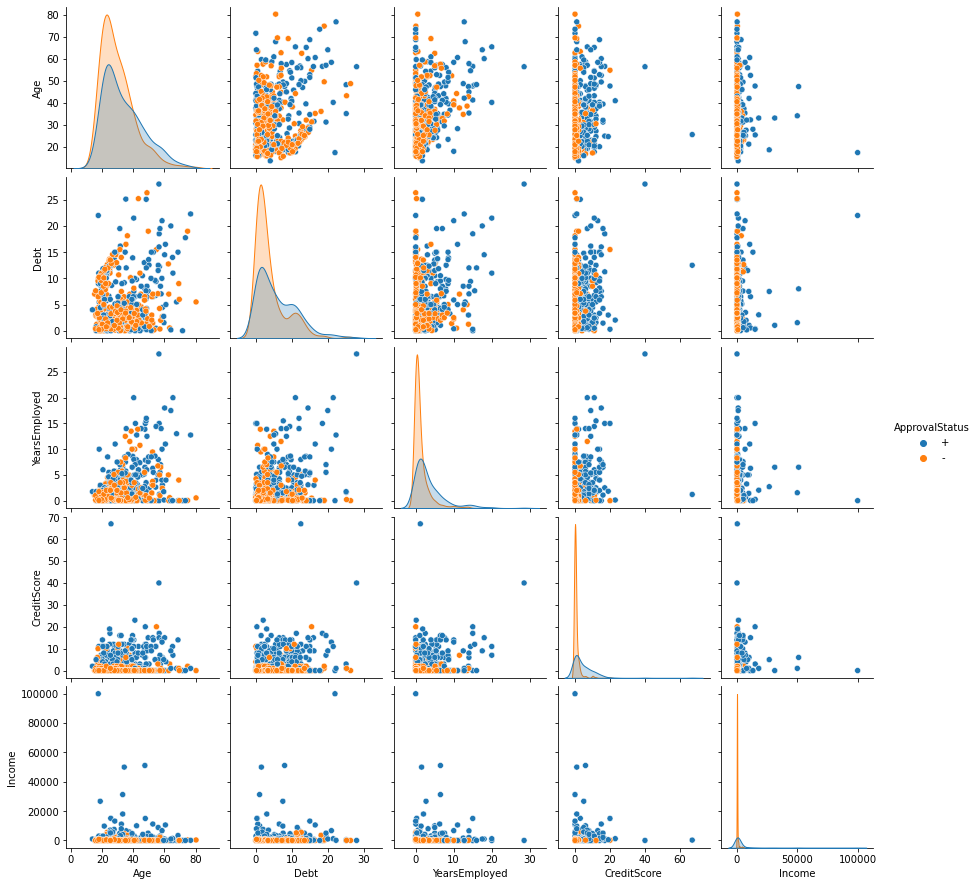

In [8]:
#Exploratory Data Analysis
sns.pairplot(cc_df, hue='ApprovalStatus')
plt.show()

<AxesSubplot:xlabel='ApprovalStatus', ylabel='Income'>

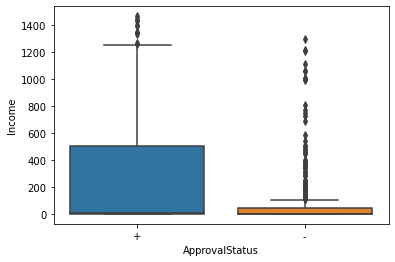

In [9]:
#The income feature is hard to visualize, so we'll take another look zoomed in
plot_df = cc_df
plot_df = plot_df[plot_df.Income < 1500]
sns.boxplot(data=plot_df, x='ApprovalStatus', y='Income')

In [10]:
#Basic Statistical Analysis of all features
cc_df.describe(include='all')

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,ApprovalStatus
count,678,678.000000,690.000000,684,684,681,681,690.000000,690,690,690.00000,690,690,545,690.000000,690
unique,2,NaN,NaN,3,3,14,9,NaN,2,2,NaN,2,3,169,NaN,2
top,b,NaN,NaN,u,g,c,v,NaN,t,f,NaN,f,g,00200,NaN,-
freq,468,NaN,NaN,519,519,137,399,NaN,361,395,NaN,374,625,35,NaN,383
mean,NaN,31.568171,4.758725,NaN,NaN,NaN,NaN,2.223406,NaN,NaN,2.40000,NaN,NaN,NaN,1017.385507,NaN
std,NaN,11.957862,4.978163,NaN,NaN,NaN,NaN,3.346513,NaN,NaN,4.86294,NaN,NaN,NaN,5210.102598,NaN
min,NaN,13.750000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,22.602500,1.000000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.00000,NaN,NaN,NaN,0.000000,NaN
50%,NaN,28.460000,2.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.00000,NaN,NaN,NaN,5.000000,NaN
75%,NaN,38.230000,7.207500,NaN,NaN,NaN,NaN,2.625000,NaN,NaN,3.00000,NaN,NaN,NaN,395.500000,NaN


## Prepare Data
<li>Split into Train/Test, Feature Selection using statistical analysis, impute/remove missing data points, OHE, and scaling.</li>


In [11]:
#Split Data
train_data, test_data = train_test_split(cc_df, test_size=0.2, random_state=42)

In [12]:
#Feature Selection - Statistical analysis (Between a numerical & categorical var
def ttest_significance(df, numerical, threshold, binary_cat_var):
    results = {}
    filter_pos = cc_df[binary_cat_var] == '+'
    filter_neg = cc_df[binary_cat_var] == '-'
    for col in numerical:
        t_stat, pval = ttest_ind(df[col][filter_pos], df[col][filter_neg], nan_policy='omit')
        results[col] = pval
    return [key for key, value in results.items() if value < threshold], results

In [13]:
numerical = [col for col in cc_df.dtypes.index if cc_df.dtypes.loc[col] != 'object']

selected, results = ttest_significance(train_data, numerical, 0.02, 'ApprovalStatus')
results = pd.DataFrame(results.items(), columns=['Numerical Column', 'p_value'])
results

,Numerical Column,p_value
0,Age,6.534643e-06
1,Debt,3.852977e-06
2,YearsEmployed,4.929122e-15
3,CreditScore,3.096529e-24
4,Income,2.371742e-05


In [14]:
#All numerical Variables make the cutoff
selected

['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income']

In [15]:
#Feature Selection - Statistical analysis (categorical & categorical)
def chi2_significance(df, categorical_cols, threshold, cat_col):
    results = {}
    for col in categorical_cols:
        contingency_table = pd.crosstab(df[col], df[cat_col])
        chi_stat, p_val, dof, expected_table = chi2_contingency(contingency_table)
        results[col] = p_val
    return [key for key, value in results.items() if value < threshold], results

In [16]:
categorical = [col for col in cc_df.dtypes.index if cc_df.dtypes.loc[col] == 'object' and col != 'ApprovalStatus']

selected, results = chi2_significance(train_data, categorical, 0.02, 'ApprovalStatus')
results = pd.DataFrame(results.items(), columns=['Categorical Column', 'p_val'])
results

,Categorical Column,p_val
0,Gender,4.557974e-01
1,Married,1.410850e-05
2,BankCustomer,1.410850e-05
3,EducationLevel,1.815968e-12
4,Ethnicity,4.052656e-07
5,PriorDefault,2.552520e-66
6,Employed,7.663266e-27
7,DriversLicense,2.870409e-01
8,Citizen,1.099820e-02
9,ZipCode,3.011911e-02


In [17]:
#Gender, DriversLicense, ZipCode do not make the cutoff
selected

['Married',
 'BankCustomer',
 'EducationLevel',
 'Ethnicity',
 'PriorDefault',
 'Employed',
 'Citizen']

In [18]:
#Finish Feature Selection by dropping columns
train_data.drop(columns=['Gender', 'DriversLicense', 'ZipCode'], inplace=True)
test_data.drop(columns=['Gender', 'DriversLicense', 'ZipCode'], inplace=True)

C:\Users\saisu\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [19]:
#Check if there is missing data
train_data.isna().sum()

Age               9
Debt              0
Married           6
BankCustomer      6
EducationLevel    9
Ethnicity         9
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
Citizen           0
Income            0
ApprovalStatus    0
dtype: int64

In [20]:
#Custom function to impute categorical data using 'most frequent' approach
def categorical_imputer(df):
    cat_cols = [col for col in df.columns if df.dtypes.loc[col] == 'object']
    for col in cat_cols:
        most_freq = df[col].value_counts().index[0]
        df[col].fillna(most_freq, inplace=True)
    return df

In [21]:
#Impute categorical features separately
train_data = categorical_imputer(train_data)
test_data = categorical_imputer(test_data)

C:\Users\saisu\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [22]:
#Custom function to impute categorical data using 'mean' approach
def numerical_imputer(df):
    num_cols = [col for col in df.columns if df.dtypes.loc[col] != 'object']
    for col in num_cols:
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df
#Alternatively can convert to OHE and then IterativelyImpute missing numerical data, but missing data is miniscule

In [23]:
#Impute numerical features separately
train_data = numerical_imputer(train_data)
test_data = numerical_imputer(test_data)

In [25]:
#Check if missing data has been filled
train_data.isna().sum()

Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
Citizen           0
Income            0
ApprovalStatus    0
dtype: int64

In [26]:
#Convert Categorical Features to Numerical using OHE
#Define list of categorical features
cat_cols = [col for col in train_data.columns if train_data.dtypes.loc[col] == 'object']

ohe = OneHotEncoder(sparse=False)
train_cat = train_data[cat_cols]
train_ohe_cat = ohe.fit_transform(train_cat)

In [27]:
#OHE renames columns to numbers. The values of the columns have also been anonymized 
#Must recreate column names as 'Cat - Col Value' so they are identifiable
columns = {}
for col, array in zip(cat_cols, ohe.categories_):
    columns[col] = array
final_columns = []
for key, values in columns.items():
    for value in values:
        final_columns.append(f'{key} - {value}')
print(final_columns)

['Married - l', 'Married - u', 'Married - y', 'BankCustomer - g', 'BankCustomer - gg', 'BankCustomer - p', 'EducationLevel - aa', 'EducationLevel - c', 'EducationLevel - cc', 'EducationLevel - d', 'EducationLevel - e', 'EducationLevel - ff', 'EducationLevel - i', 'EducationLevel - j', 'EducationLevel - k', 'EducationLevel - m', 'EducationLevel - q', 'EducationLevel - r', 'EducationLevel - w', 'EducationLevel - x', 'Ethnicity - bb', 'Ethnicity - dd', 'Ethnicity - ff', 'Ethnicity - h', 'Ethnicity - j', 'Ethnicity - n', 'Ethnicity - o', 'Ethnicity - v', 'Ethnicity - z', 'PriorDefault - f', 'PriorDefault - t', 'Employed - f', 'Employed - t', 'Citizen - g', 'Citizen - p', 'Citizen - s', 'ApprovalStatus - +', 'ApprovalStatus - -']


In [28]:
#Convert to DataFrame with clearly labelled columns
train_ohe_cat = pd.DataFrame(train_ohe_cat, columns=final_columns)

In [30]:
#Inspect
train_ohe_cat.head()

,Married - l,Married - u,Married - y,BankCustomer - g,BankCustomer - gg,BankCustomer - p,EducationLevel - aa,EducationLevel - c,EducationLevel - cc,EducationLevel - d,...,Ethnicity - z,PriorDefault - f,PriorDefault - t,Employed - f,Employed - t,Citizen - g,Citizen - p,Citizen - s,ApprovalStatus - +,ApprovalStatus - -
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [31]:
#Repeat for test data (OHE & convert to DF)
test_cat = test_data[cat_cols]
test_ohe_cat = ohe.transform(test_cat)

test_ohe_cat = pd.DataFrame(test_ohe_cat, columns=final_columns)

In [32]:
#OHE would make ~800 columns if we didn't separate the numerical, so now we have to add it back in
#Get df's for numerical features (both train & test)
train_num = train_data[[col for col in train_data.columns if col not in cat_cols]].reset_index(drop=True)
test_num = test_data[[col for col in test_data.columns if col not in cat_cols]].reset_index(drop=True)


In [33]:
#Create final datasets by adding numerical df with categorical df
train_data_final = pd.concat([train_num, train_ohe_cat], axis=1)
test_data_final = pd.concat([test_num, test_ohe_cat], axis=1)

In [34]:
#Separate out y feature (1 is + and 0 is - so we take 2nd last column for y)
X_train, y_train = train_data_final.iloc[:, :-1].values, train_data_final.iloc[:, [-2]].values
X_test, y_test = test_data_final.iloc[:, :-1].values, test_data_final.iloc[:, [-2]].values

In [35]:
#Instantiate scaler object and standard scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Building the Classifier
<li>Instantiate Logisitic Regression Classifier, train and evaluate our model</li>

In [37]:
#Instantiate Logistic Regression Model and Fit to Data
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train.ravel())

LogisticRegression()

In [38]:
#Score model on training data
lr.score(X_train_scaled, y_train)

1.0

In [39]:
#Score model on testing data (if it's significantly lower we may have to introduce regularization)
lr.score(X_test_scaled, y_test)

1.0

In [41]:
#Create a confusion matrix to view exact predictions
y_pred = lr.predict(X_test_scaled)
pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Actual Negative', 'Actual Positive']).set_axis(['Predicted Negative', 'Predicted Positive'])

,Actual Negative,Actual Positive
Predicted Negative,68,0
Predicted Positive,0,70


In [42]:
#We got a perfect model (usually not possible, will continue investigating as if we did not get such a score)

## Hyperparameter Tuning
<li>Optimizing LR model with GridSearchCV. (penalty type, regularization strength)</li>

In [44]:
#Instantiate new model and perform gridsearch to optimize
model = LogisticRegression()
param_grid = {
    'solver': ['liblinear'], 
    'penalty' : ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]
}

gs_cv = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

In [45]:
#Fit the search algo and see the best performance
gs_cv.fit(X_train_scaled, y_train.ravel())
print(gs_cv.best_estimator_)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')


In [47]:
#Recreate a new grid to investigate closer to our previous 'best value'
param_grid = {
    'solver': ['liblinear'], 
    'penalty' : ['l1'],
    'C': np.logspace(-3,-1, 25)
}

gs_cv = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

In [49]:
#Find ideal model and ideal score
gs_cv.fit(X_train_scaled, y_train.ravel())
print(gs_cv.best_estimator_)
print(gs_cv.best_score_)

LogisticRegression(C=0.004641588833612777, penalty='l1', solver='liblinear')
1.0


In [83]:
#Instantiate a new model with our ideal configurations (default had 100% so no need to, but normally would)
ideal_model = LogisticRegression()

## Pipeline
<li>Organize steps into a Pipeline for simplicty and ease.</li>

In [100]:
#Used custom functions last time, but it's cleaner with Sci-kit Learn's built in functionalities)

#Create pipeline for preprocessing numerical features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])

#Create pipeline for preprocessing categorical features
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder())])

In [101]:
#Explicitly state which features are numerical and categorical for transformer
numeric_features = ['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income']
categorical_features = ['Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'PriorDefault', 'Employed']

In [102]:
#Create ColumnTransformer object containing both preprocessors
preprocessor = ColumnTransformer(transformers=[('numerical',numeric_transformer, numeric_features), 
                                               ('categorical', categorical_transformer,categorical_features )])

In [103]:
#Construct pipeline using columntransformer and ideal model
ml_pipeline =  Pipeline(steps=[('preprocesser', preprocessor), ('ideal_lr', ideal_model)])

In [104]:
#Prep data to be ingested by Pipeline (drop cols, define X,y, split data)
data_col_dropped = cc_df.drop(columns=['Gender', 'DriversLicense', 'ZipCode'])
X = data_col_dropped.iloc[:, :-1]
y = data_col_dropped.iloc[:, -1].map({'+': 1, '-': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train pipeline
ml_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Debt',
                                                   'YearsEmployed',
                                                   'CreditScore', 'Income']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                      